# Natural Language Processing for Amazon Toys Categorization

## Author: 
Michael Weiherer </p>

Johannes Georg Larcher </p>

***Studies:*** Machine Learning ILV </p>

***Lector:*** Lukas Huber, MSc </p>

***University:*** Fachhochschule Kufstein Tirol </p>




# Comment Lucas:
#### Abgabe 2:  	

sehr interessante Umsetzung von NLP - spannend was ihr in eurem WS3 abgeben werdet. \
Hoffe es gibt noch mehr Gelegenheit die Klassifiaktion von Amazon genauer anzusehen und Amazon erlaubt solche Vorgänge.

#### Angabe 3:
Zeigt die Anwendbarkeit und bringt euer “Projekt” zum Abschluss. Beantwortet ein “Big-Picture” - was war/ist das Problem und die Ausgangssituation? Was konntet ihr verbessern? Was sind weitere Möglichkeiten für zukünftige Entwicklungen? Was lief gut, was weniger?

- Anwendung von einem der Vorhergehenden Themen (DL, CNN, GAN, NLP, Time-Series, OCR,…) - Bindet das Thema ein.
- Wovon kann euer Projekt profitieren?
- Sind Limitationen zu erwarten (Hardware, Datenqualität, …) bzw. aufgetreten?


## 1.) Project Goal

Our goal is to identify the category of toys products of Amazon by its item-name. As a first step we decided to check if a toy is a Game/Puzzle or not. Therefore we are going to use the Natural Language Processing feature and different neural nets for optimization and testing. 

# 2.) Initial Situation / Status Quo
Currently the categorization of products on our page is defined by the input of the manufacturers through their external portal (VendorCentral). Therefore manufacturers choose the category/subcategory in which those products belong. \
As they 

## 2.) Project Setup

First of all, we have loaded the appropiate packages for our project and the pre processed data as csv. 

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import seaborn as sns

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/rawdata2.csv", encoding='latin-1')

## 3.) Project Analysis 

Next step was to get a look at the pre processed data (check for missing values, check for distributions) 

In [3]:
data.head()

,Identifier,Item_Name,Category
0,B019YGSAPW,Ravensburger Spiele 23409 - Schwarzer Peter Mi...,0300 Games & Puzzles
1,B000QGRCN6,Henrys A01002-S01 - Yo-Yo Ersatzschnüre 6 Stüc...,0900 Outdoor & Sports Toys
2,B00KB45ULE,"London Teddy Bears 4X-CLQL-QFJN Sorry, es TUT ...",0700 Plush
3,B07NDXZ8ZH,KiddyMoon 90X30cm/300 Bälle ? 7Cm Bällebad Bab...,0900 Outdoor & Sports Toys
4,B079QGYCS7,Eichhorn 100003408 - Musik Set enthält Trommel...,1300 All Other


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39500 entries, 0 to 39499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Identifier  39500 non-null  object
 1   Item_Name   39500 non-null  object
 2   Category    39500 non-null  object
dtypes: object(3)
memory usage: 925.9+ KB


In [31]:
data.isna().any()

Identifier    False
Item_Name     False
Category      False
dtype: bool

In [4]:
data["Category"][3]

'0900 Outdoor & Sports Toys'

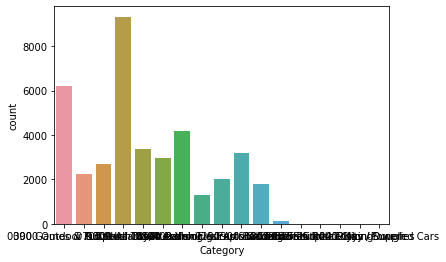

In [5]:
sns.countplot(x='Category', data=data)

## 4.) Preprocess Text

In this next step, we deleted values (html-tags, punctuations and numbers etc.) We deleted these values to ensure a good performance for the neural nets. 

In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

## 5.) Split between Features (X) to predict (y) | Implement Train-Test-Split

In [8]:
X = []
sentences = list(data['Item_Name'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:
X[3]

'KiddyMoon cm lle Cm llebad Baby Spielbad Mit Bunten llen Rund Made In EU Hellgrau Perle Blau Baby Blau Transparent Silbern'

In [10]:
y = data['Category']

y = np.array(list(map(lambda x: 1 if x=="0300 Games & Puzzles" else 0, y)))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## 6.) Tokenizer

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

**Padding:** We used the so called padding method to ensure that X_train and X_test have the same length otherwise we would not be able to work with our data. 

In [13]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
X_train

array([[ 357,    0,    0, ...,    0,    0,    0],
       [ 173, 1169,  283, ...,    0,    0,    0],
       [1078,  386, 1798, ...,    0,    0,    0],
       ...,
       [ 212,   30,  989, ...,    0,    0,    0],
       [ 144,  301,  331, ...,    0,    0,    0],
       [  49,   36,    9, ...,    0,    0,    0]])

## 7.) Embedded Dictionary

We will use Glove embeddings to create our feature matrix. In the script we load the Glove word embeddings and create a dictionary. This will contain words as keys and their corresponding embedding list as values.

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


In [16]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## 8.) Simple Neural Network

In [17]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2881100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 2,891,101
Trainable params: 10,001
Non-trainable params: 2,881,100
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 25280 samples, validate on 6320 samples
Epoch 1/10
25280/25280 [==============================] - 1s 29us/step - loss: 0.6616 - acc: 0.8443 - val_loss: 0.6323 - val_acc: 0.8411
Epoch 2/10
25280/25280 [==============================] - 1s 25us/step - loss: 0.6066 - acc: 0.8443 - val_loss: 0.5842 - val_acc: 0.8411
Epoch 3/10
25280/25280 [==============================] - 1s 26us/step - loss: 0.5633 - acc: 0.8443 - val_loss: 0.5466 - val_acc: 0.8411
Epoch 4/10
25280/25280 [==============================] - 1s 26us/step - loss: 0.5297 - acc: 0.8443 - val_loss: 0.5176 - val_acc: 0.8411
Epoch 5/10
25280/25280 [==============================] - 1s 25us/step - loss: 0.5037 - acc: 0.8443 - val_loss: 0.4955 - val_acc: 0.8411
Epoch 6/10
25280/25280 [==============================] - 1s 26us/step - loss: 0.4840 - acc: 0.8443 - val_loss: 0.4788 - val_acc: 0.8411
Epoch 7/10
25280/25280 [==============================] - 1s 25us/step - loss: 0.4692 - acc: 0.8443 - val_loss: 0.4664 - val_acc:

### 8.1 Results

In [20]:
score = model.evaluate(X_test, y_test, verbose=1)

7900/7900 [==============================] - 0s 28us/step


In [21]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4477677484856376
Test Accuracy: 0.8399999737739563


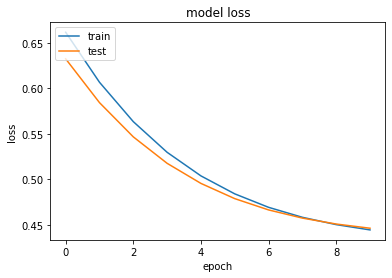

In [22]:
import matplotlib.pyplot as plt

#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train','test'], loc='upper left')
#plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 9.) Recurrent Neural Network (LSTM) 

In [23]:
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM


model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [24]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2881100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,998,477
Trainable params: 117,377
Non-trainable params: 2,881,100
_________________________________________________________________
None


In [25]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 25280 samples, validate on 6320 samples
Epoch 1/6
25280/25280 [==============================] - 80s 3ms/step - loss: 0.4448 - acc: 0.8443 - val_loss: 0.4454 - val_acc: 0.8411
Epoch 2/6
25280/25280 [==============================] - 109s 4ms/step - loss: 0.4337 - acc: 0.8443 - val_loss: 0.4397 - val_acc: 0.8411
Epoch 3/6
25280/25280 [==============================] - 107s 4ms/step - loss: 0.4336 - acc: 0.8443 - val_loss: 0.4389 - val_acc: 0.8411
Epoch 4/6
25280/25280 [==============================] - 109s 4ms/step - loss: 0.4336 - acc: 0.8443 - val_loss: 0.4378 - val_acc: 0.8411
Epoch 5/6
25280/25280 [==============================] - 109s 4ms/step - loss: 0.4331 - acc: 0.8443 - val_loss: 0.4382 - val_acc: 0.8411
Epoch 6/6
7900/7900 [==============================] - 7s 935us/step


In [26]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.43975804476798336
Test Accuracy: 0.8399999737739563


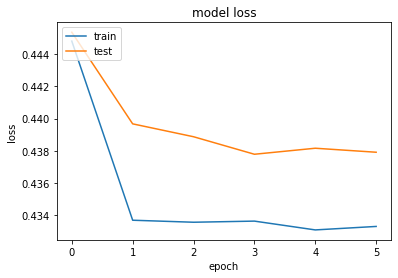

In [27]:
import matplotlib.pyplot as plt

#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train','test'], loc='upper left')
#plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 10.) Predict a random toy

In [28]:
instance = X[57]
print(instance)


Jamara RC Audi LMS silber


In [29]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.1649089]], dtype=float32)

## Result

As an result our model predicted 0,1649089. This means that our sigmoid functions predicts a floating value between 0 and 1. Therefore in our case the model predicted the above mentiond value. So when we have a look out our instace (Jamara RC Audi LMS silber) and search for it in our data we saw that it is categorized not as a Game/Puzzle. Our model also predicted it not to be a Game/Puzzle. 

So we can say that: 

under 0.5 = No Game/Puzzle </p>
above 0.5 = Game/Puzzle